In [55]:
import numpy as np
import math
import matplotlib.pyplot as plt

XM_PI = 3.141592654
XM_PIDIV2 = XM_PI * 0.5
XM_SH_MAXORDER = 6
def GetSpherePosInBox(pos, center, size):
    uv = (pos - center) / size
    offset = uv[0]*uv[0] + uv[1]*uv[1]
    if offset > 1.0:
        return np.float32([0, 0, 0, 0])
    
    z = np.sqrt(1.0 - offset)
    return np.float32([uv[0], uv[1], z, 1.0])
def ComputeCapInt(order, fConeAngle):
    fTmpL0 = np.zeros(XM_SH_MAXORDER)
    
    cos_fConeAngle = math.cos(fConeAngle)
    sin_fConeAngle = math.sin(fConeAngle)
    t2 = cos_fConeAngle
    t3 = np.sqrt(np.pi / 10.0)*cos_fConeAngle
    t7 = sin_fConeAngle
    t8 = sin_fConeAngle**2
    
    cap_int_t1 = np.sqrt(np.pi/10.0)
    fTmpL0[0] = -t3 * cap_int_t1
    fTmpL0[1] = np.sqrt(3.0) * cap_int_t1 * t8 / 2.0
    
    t13 = t2**2
    fTmpL0[2] = -np.sqrt(5.0) * cap_int_t1 * t2 * (t13 - 1)/2.0
    
    t19 = np.sqrt(7.0)*cap_int_t1
    t20 = t13**2
    fTmpL0[3] = -5.0/8.0*t19*t20 + 3.0/4.0*t19*t13 - t19/8.0
    
    fTmpL0[4] = -3.0/8.0*t3*(7.0*t20 - 10.0*t13 + 3.0)
    
    t33 = np.sqrt(11.0) * cap_int_t1
    fTmpL0[5] = -21.0/16.0*t33*t20*t13 + 35.0/16.0*t33*t20 - 15.0/16.0*t33*t13 + t33/16.0
    
    return fTmpL0

def sh_eval_basis_2(x, y, z):
    out = np.zeros(9)
    
    # l=0, m=0
    p00 = 0.282094791773878140
    out[0] = p00
    
    # l=1
    p10 = 0.488602511902919920
    p11 = -0.488602511902919920
    out[1] = p11*y # m=-1
    out[2] = p10*z # m=0
    out[3] = p11*x # m=+1
    
    # l=2
    p20 = 0.946174695757560080 * z**2 + -0.315391565252520050
    p21 = -1.092548430592079200
    p22 = 0.546274215296039590
    out[4] = p22*2*x*y # m=-2
    out[5] = p21*y # m=-1
    out[6] = p20 # m=0
    out[7] = p21*x # m=+1
    out[8] = p22*(x**2 - y**2) # m=+2
    
    return out
    
def XMSHEvalSphericalLight(pos, radius, order: int =3):
    fDist = np.linalg.norm(pos)
    if fDist <= radius:
        fConeAngle = np.pi / 2.0 
    else:
        fConeAngle = math.asin(radius / fDist)
        
    direction = pos / fDist
    fNewNorm = 1.0
    fTmpL0 = ComputeCapInt(order, fConeAngle)
    
    lightSH = sh_eval_basis_2(direction[0], direction[1], direction[2])
    
    fv0 = 0*2+1
    fValUse0 = fTmpL0[0]*1.0*(2.0*fv0*np.sqrt(fv0*np.pi))
    lightSH[0] = fValUse0*lightSH[0]
    
    fv1 = 1*2+1
    fValUse1 = fTmpL0[1]*1.0*(2.0*fv1*np.sqrt(fv1*np.pi))
    lightSH[1] = fValUse1*lightSH[1]
    lightSH[2] = fValUse1*lightSH[2]
    lightSH[3] = fValUse1*lightSH[3]
    
    fv2 = 2*2+1
    fValUse2 = fTmpL0[2]*1.0*(2.0*fv2*np.sqrt(fv2*np.pi))
    lightSH[4] = fValUse2*lightSH[4]
    lightSH[5] = fValUse2*lightSH[5]
    lightSH[6] = fValUse2*lightSH[6]
    lightSH[7] = fValUse2*lightSH[7]
    lightSH[8] = fValUse2*lightSH[8]
    return lightSH

def Eval3(lightSH, normalSH):
    # Lambertian diffuse per-band convolution coefficients
    r = 1.0
    g = 2.0/3.0
    b = 1.0/4.0
    
    # evaluate exit radiance in direction of normal
    c = 0.0
    c = r *(normalSH[0]*lightSH[0])\
        + g*(normalSH[1]*lightSH[1] + normalSH[2]*lightSH[2]) \
        + b*(normalSH[3]*lightSH[3] + normalSH[4]*lightSH[4] + normalSH[5]*lightSH[5] + normalSH[6]*lightSH[6] + normalSH[7]*lightSH[7] + normalSH[8]*lightSH[8])
    return c
    
def PointOrder3(sphere_pos):
    up = np.float32([0, 1, 0])
    lightSH = XMSHEvalSphericalLight(4.0*up, 1.0, order=3)
    normalSH = sh_eval_basis_2(sphere_pos[0], sphere_pos[1], sphere_pos[2])
    c = Eval3(lightSH, normalSH)
    c = np.clip(c, a_min=0.0, a_max=1.0)
    
    return c, normalSH, lightSH

(3207, 4) (4096, 9) (4096, 9)


<IPython.core.display.Javascript object>


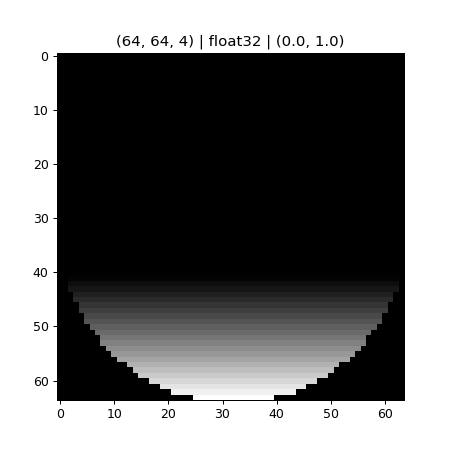

In [56]:
img_size = 64
image = np.zeros((img_size, img_size, 4)).astype(np.float32)

sphere_poses = []
normalSHs = []
lightSHs = []

grid_center = np.float32([image.shape[1], image.shape[0]]) / 2.0
min_axis = image.shape[0] / 2.0
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        sphere_pos = GetSpherePosInBox([x, y], grid_center, min_axis)
        if np.linalg.norm(sphere_pos) > 0:
            sphere_poses.append(sphere_pos)
        result, normalSH, lightSH = PointOrder3(sphere_pos)
        normalSHs.append(normalSH)
        lightSHs.append(lightSH)
        image[y, x, :] = result
sphere_poses = np.float32(sphere_poses)
normalSHs = np.float32(normalSHs)
lightSHs = np.float32(lightSHs)
print(sphere_poses.shape, normalSHs.shape, lightSHs.shape)
image = (image - np.min(image)) / (np.max(image) - np.min(image))
plt.figure(figsize=(5, 5))
plt.imshow(image[..., :3], vmin=np.min(image), vmax=np.max(image))
plt.title('{} | {} | ({}, {})'.format(image.shape, image.dtype, np.min(image), np.max(image)))
plt.show()

<IPython.core.display.Javascript object>


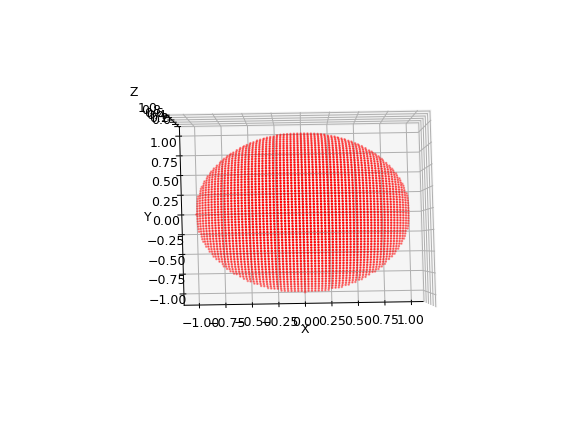

In [27]:
%matplotlib notebook
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(sphere_poses[:,0], sphere_poses[:,1], sphere_poses[:,2], c='r', s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# SH

In [32]:
sqrt_pi = np.sqrt(np.pi)
p00 = 1/(2.0*sqrt_pi)
p11 = -np.sqrt(3)/(2.0*sqrt_pi)
p10 = np.sqrt(3)/(2.0*sqrt_pi)

p21 = np.sqrt(15)/(2.0*sqrt_pi)
p20a = np.sqrt(5)*3/(4.0*sqrt_pi)
p20b = np.sqrt(5)*-1/(4.0*sqrt_pi)
p22 = np.sqrt(15)/(4.0*sqrt_pi)

print('p00 = {}'.format(p00))
print('p10 = {}'.format(p10))
print('p11 = {}'.format(p11))
print('p20a= {}'.format(p20a))
print('p20b= {}'.format(p20b))
print('p21 = {}'.format(p21))
print('p22 = {}'.format(p22))


p00 = 0.28209479177387814
p10 = 0.4886025119029199
p11 = -0.4886025119029199
p20a= 0.9461746957575602
p20b= -0.31539156525252005
p21 = 1.0925484305920792
p22 = 0.5462742152960396


xyz: (2500, 3)


<IPython.core.display.Javascript object>


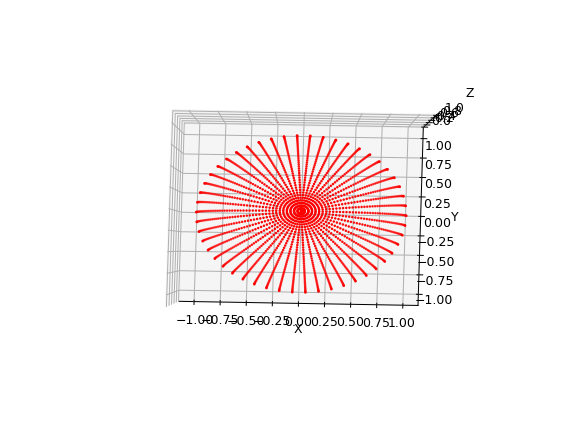

In [49]:
phis = np.arange(0, 2*np.pi, 2*np.pi / 50)
thetas = np.arange(0, np.pi/2.0, np.pi/2.0 / 50)

xyz = []
for i in range(len(thetas)):
    for j in range(len(phis)):
        theta = thetas[i]
        phi = phis[j]
        x = np.sin(theta)*np.cos(phi)
        y = np.sin(theta)*np.sin(phi)
        z = np.cos(theta)
        xyz.append([x, y, z])
xyz = np.float32(xyz)
print('xyz:', xyz.shape)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c='r', s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# SH visualization

Azimuthal quantum number "l": 1
Magnetic quantum number "m": 1


<IPython.core.display.Javascript object>


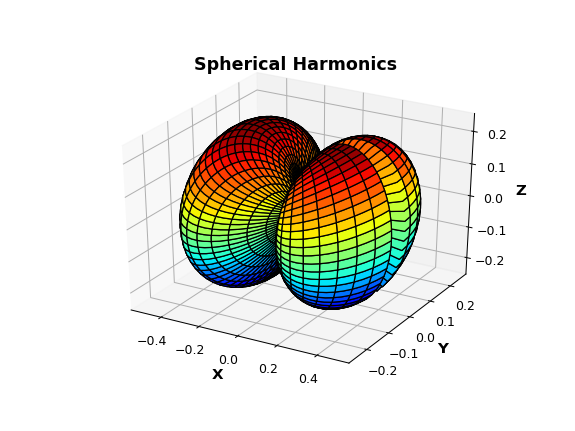

In [53]:

from numpy import sin, cos, pi, sqrt, shape, linspace, meshgrid, zeros
from math import factorial

def Shperical2Cartesian(r, theta, phi):

    x = r* sin(theta)* cos(phi)
    y = r* sin(theta)* sin(phi)
    z = r* cos(theta)
    
    return x, y, z

#%% Legendre Polynomials

def Legendre_Poly(n, x):

    if n == 0:
        P = 1
        
    elif n == 1:
        P = x
        
    else:
        P = (1/n)* ((2*n - 1)* x* Legendre_Poly(n-1, x) - (n - 1)* Legendre_Poly(n-2, x))

    return P

#%% Associated Legendre Polynomials

def Asso_Leg(l, m, x):
    
    try:
        if m == 0:
            P = Legendre_Poly(l, x)
            
        elif m > 0:
            P = (1/ sqrt(1 - x**2))* ((l-m+1)* x* Asso_Leg(l, m-1, x) \
                                    - (l+m-1)* Asso_Leg(l-1, m-1, x) )
                                
        elif m < 0:
            m = abs(m)
            P = ((-1)**m) * (factorial(l - m)/ factorial(l + m))* Asso_Leg(l, m, x)
            
    except ZeroDivisionError:
        P = 0
    
    return P

#%% Main code
    
''' Now all functions are defined
    So we are ready to use it '''
    
#%% Azimuthal and Magnetic quantum nubers

l = int(input('Azimuthal quantum number "l": '))

if l < 0:
    print('"l" can not be a negative number')

m = int(input('Magnetic quantum number "m": '))

if m > l or m < (-l):
    print('quntum number "m" belong to "[-l,l]"')

#%%  Normalization constant

K = sqrt( ((2*l + 1)* factorial(l - abs(m)))/ (4* pi* factorial(l + abs(m))) )

#%% Value of Phi and Theta

phi = linspace(0, 2* pi, 100)
tht = linspace(0, pi, 100)

Phi, Tht = meshgrid(phi, tht)

#%% Value of Y

p, q = shape(Phi)
Y    = zeros([p, q])

for i in range(0 + 1, p - 1):
    for j in range(0 + 1, q - 1):

        if m > 0:
        
            Y[i, j] = sqrt(2)* K* cos(m* Phi[i, j])* Asso_Leg(l, m, cos(Tht[i, j]))
        
        elif m < 0:
        
            Y[i, j] = sqrt(2)* K* sin(abs(m)* Phi[i, j])* Asso_Leg(l, abs(m), cos(Tht[i, j]))
        
        elif m == 0:
        
            Y[i, j] = K* Legendre_Poly(l, cos(Tht[i, j]))


#%% Take care about negative Y
p, q = shape(Y)

for i in range(0, p):
    for j in range(0, q):

        if Y[i, j] < 0:
            Tht[i, j] = Tht[i, j] + pi

#%% Finally convert data to cartesian form

x, y, z = Shperical2Cartesian(Y, Tht, Phi)

#%% plotting

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mp3d

fig = plt.figure('Harmonics')
ax = fig.add_subplot( 111 , projection='3d')

ax.plot_surface(x, y, z, cmap = 'jet', edgecolor = 'k')
plt.title('Spherical Harmonics', fontsize = 14, fontweight = 'bold')
ax.set_xlabel('X', fontsize = 12, fontweight = 'bold')
ax.set_ylabel('Y', fontsize = 12, fontweight = 'bold')
ax.set_zlabel('Z', fontsize = 12, fontweight = 'bold')
plt.show()